# AutoGrad

In [44]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes = set(); edges = set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR -> left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f}" % (n.label, n.data), shape = 'record') # for value in the graph create a record for it
        if n._op:
            # if this node is the result of an operation then we create a node to signify it
            dot.node(name = uid + n._op, label = n._op)
            # and connect node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

#### Implemeting __rmul__, exp and powers in the `Value` class

In [51]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other) # this functionality allows us to directly perform operation with non Value obejcts by explicitly first converting it to Value object
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, {self, other}, '*') 
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += (other) * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        vis = set()
        def build_topo(v):
            if v not in vis:
                vis.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()

#### Testing all basic operations with `Value` objects

In [52]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [34]:
a * 2

Value(data=4.0)

In [35]:
2 * a # this does not work as 2.__mul__(a) is not supported, so we need to create a __rmul__ to handle this case

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

In [40]:
2 * a

Value(data=4.0)

In [47]:
a = Value(1.0)
a.exp()

Value(data=2.718281828459045)

In [50]:
a = Value(2.0); b = Value(4.0)
a / b

Value(data=0.5)

In [53]:
a = Value(2.0); b = Value(4.0)
a - b

Value(data=-2.0)

In [54]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

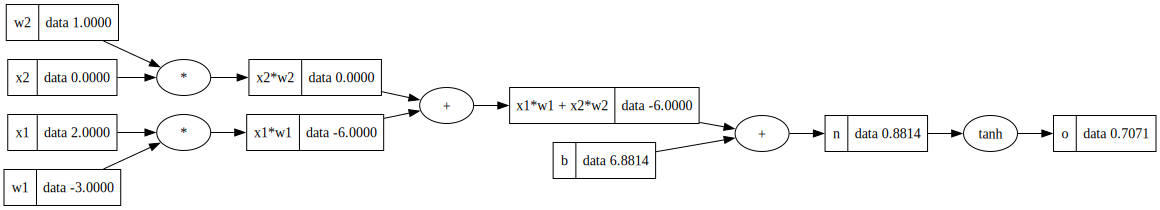

In [55]:
draw_dot(o)